## Image Orientation Corrector

In [63]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def ImageOrientation(img_path):
    # Load the image from the given path
    img = cv.imread(img_path)
    copy_1 = img.copy()

    # Convert the image to grayscale
    gray_1 = cv.cvtColor(copy_1, cv.COLOR_BGR2GRAY)

    # Apply a threshold to the image
    ret, thresh_1 = cv.threshold(gray_1, 20, 255, cv.THRESH_TOZERO)

    # Find the contours of the image
    contours_1, hierarchy = cv.findContours(thresh_1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # Draw the contours on the image
    cv.drawContours(copy_1, contours_1, -1, (0, 255, 0), 5)

    # Sorting the contours by area
    contours_1 = sorted(contours_1, key=cv.contourArea, reverse=True)

    # Printing the area of each contour
    for contour in contours_1:
        print(cv.contourArea(contour))

    # Concatenate the contours into a single contour
    single_contour = np.concatenate(contours_1)

    # Using the single_contour to draw the contour on the image
    cv.drawContours(copy_1, [single_contour], -1, (0, 255, 0), 5)

    # Using bounding rectangle to rotate the image to align properly
    rect = cv.minAreaRect(single_contour)

    box = cv.boxPoints(rect)
    box = np.int64(box)

    cv.drawContours(copy_1, [box], 0, (0, 0, 255), 2)

    # Get the rotation angle and adjust it to ensure the longer side is parallel to the x-axis
    angle = rect[2]
    if rect[1][0] < rect[1][1]:
        angle += 90
    rows, cols = img.shape[:2]
    M = cv.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    dst = cv.warpAffine(img, M, (cols, rows))

    # Making a copy of the rotated image
    copy_2 = dst.copy()
    copy_3 = dst.copy()
    
    # Drawing the contours on the rotated image copy_2
    gray_2 = cv.cvtColor(copy_2, cv.COLOR_BGR2GRAY)
    ret, thresh_2 = cv.threshold(gray_2, 20, 255, cv.THRESH_TOZERO)
    contours_2, hierarchy = cv.findContours(thresh_2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(copy_2, contours_2, -1, (0, 255, 0), 5)

    # Sorting the contours by area
    contours_2 = sorted(contours_2, key=cv.contourArea, reverse=True)


    # Finding the position of the first contour
    x_1, y_1, w_1, h_1 = cv.boundingRect(contours_2[0])
    print(x_1, y_1)

    # Rotating copy_3 by 180 degrees
    rows, cols = copy_3.shape[:2]
    M = cv.getRotationMatrix2D((cols / 2, rows / 2), 180, 1)
    dst_2 = cv.warpAffine(copy_3, M, (cols, rows))

    # Making a copy of the rotated image
    copy_4 = dst_2.copy()

    # Drawing the contours on the rotated image copy_4
    gray_3 = cv.cvtColor(copy_4, cv.COLOR_BGR2GRAY)
    ret, thresh_3 = cv.threshold(gray_3, 20, 255, cv.THRESH_TOZERO)
    contours_3, hierarchy = cv.findContours(thresh_3, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(copy_4, contours_3, -1, (0, 255, 0), 5)

    # Sorting the contours by area
    contours_3 = sorted(contours_3, key=cv.contourArea, reverse=True)

    # Printing the coordinates of the first contour
    x_2, y_2, w_2, h_2 = cv.boundingRect(contours_3[0])
    print(x_2, y_2)

    # Determine the final image orientation
    if x_1 < x_2 and y_1 < y_2:
        final_img = dst
    else:
        final_img = dst_2

    # Returning along with data of the pixel_intensity
    data = final_img[:, :, 0].astype(np.int64)
    
    # Making a copy of the final image
    final_img_copy = final_img.copy()

    return final_img, final_img_copy, data, contours_3



## Center of Mass helper function

In [48]:
def calculate_center_of_mass(contour, data):
    com_x = 0
    com_y = 0
    total_intensity = 0

    for i in range(len(data)):
        for j in range(len(data[i])):
            if cv.pointPolygonTest(contour, (j, i), False) == 1:
                com_x += j * data[i][j]
                com_y += i * data[i][j]
                total_intensity += data[i][j]

    com_x /= total_intensity
    com_y /= total_intensity

    return com_x, com_y

## 3D Plot helper function for debuggin

In [55]:
def plot_3d_surface(data, contours=None, contour=None, title='Interactive 3D Plot of Pixel Intensities', markers=[]):
    # Create a mask to highlight the contour areas
    mask = np.zeros_like(data, dtype=np.uint8)
    
    if contours is not None and len(contours) > 0:
        for cnt in contours:
            cv.drawContours(mask, [cnt], -1, (255), thickness=cv.FILLED)
    elif contour is not None:
        cv.drawContours(mask, [contour], -1, (255), thickness=cv.FILLED)

    # Apply the mask to the data
    masked_data = np.where(mask == 255, data, 0)

    # Create the surface plot
    fig = go.Figure(data=[go.Surface(z=masked_data)])

    # Add additional markers
    for marker in markers:
        fig.add_trace(go.Scatter3d(
            x=[marker['x']],
            y=[marker['y']],
            z=[np.max(masked_data)],  # Add a constant offset to ensure markers are visible
            mode='markers',
            marker=dict(
                size=4,
                color=marker['color']
            ),
            name=marker['name']
        ))

    # Update layout for better visualization
    fig.update_layout(
        scene=dict(
            xaxis_title='X Label',
            yaxis_title='Y Label',
            zaxis_title='Z Label',
            aspectratio=dict(x=1, y=1, z=0.5),
            aspectmode='manual'
        ),
        title=title
    )

    fig.show()

# Fiduciary Marker Identifier with threshold

In [44]:
def marker_finder (img, data, threshold = 70) :
    
    # Convert the image to grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Apply a threshold to the image using adaptive guassian thresholding
    ret, thresh = cv.threshold(gray, threshold, 255, cv.THRESH_TOZERO)
    
    # Find the contours of the image
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    # Draw the contours on the image
    cv.drawContours(img, contours, -1, (0, 255, 0), 2)
    
    #finding the center of mass of each contour
    com_markers = []    
    for contour in contours:
        com_markers.append(calculate_center_of_mass(contour, data))
        
    #draw the center of mass on the image
    for com in com_markers:
        cv.circle(img, (int(com[0]), int(com[1])), 3, (255, 0, 0), -1)

    
    return com_markers, contours, img


## Testing / Debuggin

3564.5
2352.0
1348.0
1185.0
1070.5
131 178
95 113


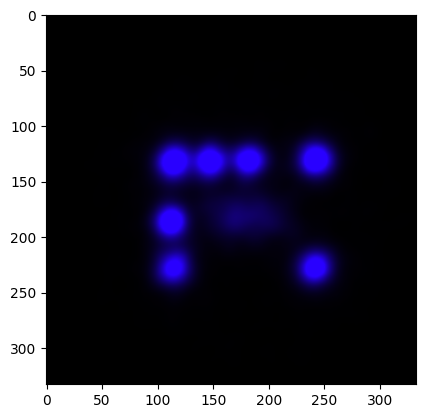

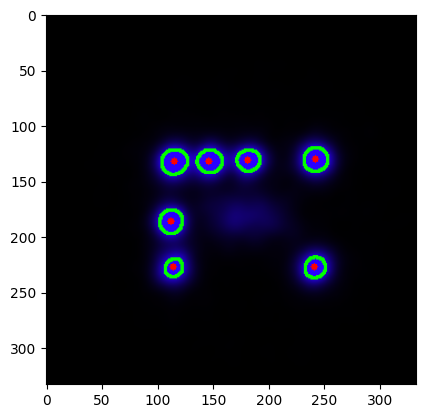

In [64]:
img, img_copy, data, contours_og = ImageOrientation('/workspaces/CSDNA/Testing code/Robot Movement/Data/t=48avg.png')

# Display the image
plt.imshow(img_copy)
plt.show()

com_markers, contours, img = marker_finder(img, data)

# Display the image
plt.imshow(img)
plt.show()

#adding all the center of mass markers to the 3D scatter plot
markers = []
for i in range(len(com_markers)):
    markers.append({'x': com_markers[i][0], 'y': -com_markers[i][1], 'color': 'red', 'name': 'COM ' + str(i+1)})
    

# Plot the 3D surface with the center of mass markers
plot_3d_surface(data, contours=contours_og, markers = markers, title='Interactive 3D Plot of Pixel Intensities with Center of Mass Markers')